# Set Paths and Files

In [1]:
import sys 
sys.path.append('..')

In [2]:
import os
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import random
import multiprocessing 
import time
from multiprocessing import Pool
multiprocessing.cpu_count()

import torch 
import time
import os, glob
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [3]:
MODEL_TO_LOAD = 'bonemeta_fn_0_3D_Unet_Res_lv6_PS128_All128_model_epoch3000'
PATCH_SIZE = (128,128,128)

# BATCH_SIZE = 120
BATCH_SIZE = 4
NUM_WORKERS = 8

BASE_DIR = '/workspace/BoneMeta_all_128'
IMG_FOLDER_NAME = 'images'
LABEL_FOLDER_NAME = 'labels'
PRED_FOLDER_NAME = 'preds'

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [4]:
PRED_DIR = os.path.join(BASE_DIR, PRED_FOLDER_NAME)
os.makedirs(PRED_DIR, exist_ok=True)
SAVING_DIR = os.path.join(PRED_DIR, MODEL_TO_LOAD)
os.makedirs(SAVING_DIR, exist_ok=True)
SAVING_DIR_NPY = os.path.join(SAVING_DIR, "numpy")
os.makedirs(SAVING_DIR_NPY, exist_ok=True)

In [5]:
IMG_DIR = os.path.join(BASE_DIR, IMG_FOLDER_NAME)
LABEL_DIR = os.path.join(BASE_DIR, LABEL_FOLDER_NAME)

IMG_FILES = os.listdir(IMG_DIR)
LABEL_FILES = os.listdir(LABEL_DIR)

def get_img_path(file): 
    return os.path.join(IMG_DIR, file)

def get_label_path(file):
    return os.path.join(LABEL_DIR, file)

def case_to_file(case):
    return case+'.npy'

def file_to_case(file_name):
    return file_name.split('.')[0]

set(IMG_FILES).issubset(LABEL_FILES)

True

In [6]:
print(IMG_DIR, len(IMG_FILES))
print(LABEL_DIR, len(LABEL_FILES))

/workspace/BoneMeta_CropSpine_all_128/images 310
/workspace/BoneMeta_CropSpine_all_128/labels 310


In [7]:
TRAIN_FILES = ['000376_20200101_abdomen.npy', '000400_20200210_chest.npy', 'BH018_20190801_abdomen.npy', 'BH062_20201104_chest.npy', '000262_20190501_abdomen.npy', 'BH007_20190801_abdomen.npy', 'BH072_20200219_chest.npy', '000251_20190701_abdomen.npy', '000368_20200101_abdomen.npy', 'BH007_20190801_chest.npy', '000224_20190228_chest.npy', 'BH066_20190525_chest.npy', 'SN054_20170201_chest.npy', '000246_20190629_chest.npy', 'SN031_20160501_chest.npy', 'SN051_20170401_chest.npy', '000272_20190614_chest.npy', '000396_20200218_chest.npy', '000305_20190801_abdomen.npy', '000450_20200501_abdomen.npy', 'BH018_20190801_chest.npy', '000404_20200305_chest.npy', 'BH020_20191201_chest.npy', 'BH008_20190701_chest.npy', 'BH021_20181001_abdomen.npy', '000352_20191017_chest.npy', 'SN036_20190601_chest.npy', 'BH045_20181001_chest.npy', '000348_20191201_CT Liver (contrast).npy', '000262_20190318_chest.npy', '000350_20190927_chest.npy', 'BH025_20191101_abdomen.npy', '000021_20181227_chest.npy', 'BH055_20200328_chest.npy', '000372_20200107_chest.npy', '000270_20190608_chest.npy', 'BH002_20190701_chest.npy', '000386_20200204_chest.npy', 'BH005_20170701_abdomen.npy', 'BH036_20180301_GU Kidney & bladder CT (3D).npy', '000331_20190916_chest.npy', 'BH013_20191001_chest.npy', '000009_20180417_chest.npy', '000291_20190718_chest.npy', '000316_20190715_Spine^L_SPINE (Adult).npy', 'BH027_20191001_chest.npy', '000302_20190726_chest.npy', '000304_20190124_chest.npy', 'BH008_20190701_abdomen.npy', '000272_20190601_abdomen.npy', 'BH043_20191001_chest.npy', 'BH043_20191001_abdomen.npy', 'BH061_20190315_chest.npy', '000396_20200201_abdomen.npy', '000019_20181018_chest.npy', '000316_20190627_chest.npy', '000311_20190902_chest.npy', '000332_20191001_abdomen.npy', 'BH037_20171101_abdomen.npy', 'BH024_20190501_abdomen.npy', '000356_20191024_chest.npy', '000331_20190901_abdomen.npy', '000091_20180504_chest.npy', '000286_20190701_abdomen.npy', 'SN055_20170301_chest.npy', 'SN005_20191101_chest.npy', 'BH070_20160823_chest.npy', '000330_20190926_chest.npy', 'BH061_20190315_abdomen.npy', 'BH024_20190501_chest.npy', 'BH032_20180701_abdomen.npy', 'SN056_20170601_Thorax^01_Lung_Cancer_3D (Adult).npy', '000309_20190801_abdomen.npy', 'BH005_20170701_chest.npy', '000285_20190807_chest.npy', '000363_20191222_chest.npy', '000080_20180911_chest.npy', '000291_20190701_abdomen.npy', 'SN007_20190701_chest.npy', '000332_20191025_chest.npy', 'BH064_20200605_chest.npy', 'BH026_20190601_abdomen.npy', 'SN015_20190901_chest.npy', '000079_20180911_Pulmonary artery CT Angio+3D (contrast).npy', '000285_20190801_abdomen.npy', 'BH023_20191101_chest.npy', '000011_20181207_chest.npy', '000242_20190409_chest.npy', 'BH004_20191101_chest.npy', '000269_20190604_chest.npy', 'SN017_20190701_chest.npy', 'BH063_20200519_chest.npy', 'BH064_20200605_abdomen.npy', 'BH016_20151001_chest.npy', 'BH051_20190301_GU Kidney & bladder CT (3D).npy', '000324_20190910_chest.npy', 'BH060_20200413_chest.npy', '000300_20190801_abdomen.npy', 'BH019_20191101_chest.npy', '000048_20190501_abdomen.npy', '000315_20190820_chest.npy', '000352_20191001_abdomen.npy', '000282_20190701_abdomen.npy', '000310_20190812_chest.npy', '000193_20190114_chest.npy', '000362_20191214_chest.npy', 'BH037_20171101_chest.npy', '000279_20190614_chest.npy', '000162_20180131_chest.npy', '000279_20190601_abdomen.npy', 'BH091_20200104_GU Kidney & bladder CT (3D).npy', '000262_20190529_chest.npy', '000450_20200512_chest.npy', '000251_20190429_chest.npy', 'BH072_20200219_abdomen.npy', '000022_20180830_chest.npy', 'BH006_20170801_chest.npy', 'BH021_20181001_chest.npy', '000296_20190726_chest.npy', '000309_20190823_chest.npy', 'BH039_20190601_chest.npy', 'BH023_20191101_abdomen.npy', 'BH010_20161101_abdomen.npy', '000012_20181214_chest.npy', 'BH065_20201013_chest.npy', 'BH045_20181001_abdomen.npy', 'BH054_20191122_abdomen.npy', '000382_20200129_chest.npy', '000310_20190801_abdomen.npy', '000019_20190613_chest.npy', 'BH056_20200721_chest.npy', '000382_20200101_abdomen.npy', 'BH020_20191201_abdomen.npy', 'BH031_20160301_CT Angio + 3D Pulmonary artery (Embolism).npy', '000269_20190601_abdomen.npy', '000404_20200201_abdomen.npy', 'SN013_20190401_chest.npy', '000344_20191125_chest.npy', 'BH110_20200616_chest.npy', '000356_20190901_abdomen.npy', 'BH016_20151001_abdomen.npy', 'BH091_20200104_chest.npy', '000251_20190703_chest.npy', '000363_20191201_abdomen.npy', '000376_20200114_chest.npy', '000350_20191001_abdomen.npy', '000212_20190324_chest.npy', '000278_20190620_chest.npy', '000362_20191201_abdomen.npy', '000372_20200101_abdomen.npy', 'BH032_20180701_chest.npy', 'BH010_20161101_chest.npy', 'BH035_20191101_GU Kidney & bladder CT (3D).npy', '000400_20200201_CT Biliary (contrast).npy', '000301_20190801_Pulmonary artery CT Angio+3D (contrast).npy', '000301_20190801_abdomen.npy', '000325_20190919_chest.npy', '000301_20190827_chest.npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy', '000273_20190531_chest.npy', 'SN029_20200301_chest.npy', 'BH069_20200505_chest.npy', 'SN002_20190801_chest.npy', '000391_20200216_Thoracic Aorta CT Angio+3D (contrast).npy']

VAL_FILES = ['000364_20191201_abdomen.npy', '000364_20191217_chest.npy', 'BH012_20180401_abdomen.npy', '000085_20180829_chest.npy', '000397_20200214_chest.npy', '000223_20190319_chest.npy', '000322_20190901_abdomen.npy', 'BH081_20190322_abdomen.npy', 'BH048_20190501_chest.npy', 'BH015_20190101_abdomen.npy', 'BH029_20200101_chest.npy', 'BH099_20200806_chest.npy', 'BH012_20180401_chest.npy', 'SN008_20190901_chest.npy', 'SN019_20190801_chest.npy', 'SN025_20200401_chest.npy', 'SN004_20190901_chest.npy', '000308_20190801_abdomen.npy', 'BH015_20190101_chest.npy', 'BH059_20201019_chest.npy', '000452_20200513_chest.npy', '000232_20190423_chest.npy', 'BH034_20190901_chest.npy', 'BH034_20190901_abdomen.npy', 'BH099_20200806_abdomen.npy', 'BH028_20190801_chest.npy', '000308_20190826_chest.npy', '000002_20180829_chest.npy', '000232_20190401_abdomen.npy', 'SN042_20170901_chest.npy', 'BH059_20201013_abdomen.npy', '000025_20180808_chest.npy', 'BH067_20191017_chest.npy', '000069_20180319_chest.npy', '000322_20190913_chest.npy']

TEST_FILES = ['000355_20190901_abdomen.npy', '000234_20190401_abdomen.npy', '000255_20190418_chest.npy', '000281_20190701_chest.npy', 'SN016_20190901_chest.npy', '000236_20190401_abdomen.npy', '000288_20190701_abdomen.npy', 'BH057_20191227_chest.npy', '000234_20190419_chest.npy', 'BH001_20190501_abdomen.npy', 'BH014_20181201_chest.npy', '000314_20190827_chest.npy', '000276_20190604_chest.npy', '000314_20190901_abdomen.npy', '000298_20190726_chest.npy', 'BH047_20180901_abdomen.npy', 'BH017_20191201_abdomen.npy', 'BH001_20190401_chest.npy', 'BH022_20190101_chest.npy', '000383_20200121_chest.npy', 'SN028_20160801_chest.npy', '000260_20190522_chest.npy', 'BH112_20190201_chest.npy', 'BH009_20180301_abdomen.npy', 'BH047_20180901_chest.npy', 'BH057_20191227_abdomen.npy', '000354_20191001_abdomen.npy', 'BH052_20190901_abdomen.npy', '000355_20191023_chest.npy', 'BH058_20180918_chest.npy', 'BH017_20191201_chest.npy', 'BH009_20180301_chest.npy', '000354_20191022_chest.npy', 'BH052_20190901_chest.npy', '000244_20190501_abdomen.npy', '000260_20190501_CT Liver (contrast).npy', 'BH014_20181201_abdomen.npy', '000214_20190325_chest.npy']

# Load Model

In [8]:
import logging
log = logging.getLogger("3DUnet")
# log.setLevel(logging.WARN)
log.setLevel(logging.INFO)
# log.setLevel(logging.DEBUG)

In [9]:
from torch.optim import SGD, AdamW, RMSprop
from torch import nn
from pytorch3dunet.unet3d.model import UNet3D, ResidualUNet3D

def initModel():    
    segmentation_model = ResidualUNet3D(in_channels=3, out_channels=1, num_groups=32, f_maps=32, final_sigmoid=True, testing=True, num_levels=6)

    # augmentation_model = SegmentationAugmentation(**self.augmentation_dict)

    if USE_CUDA:
        log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
        if torch.cuda.device_count() > 1:
            segmentation_model = nn.DataParallel(segmentation_model)
            # augmentation_model = nn.DataParallel(augmentation_model)
        segmentation_model = segmentation_model.to(DEVICE)
        # augmentation_model = augmentation_model.to(DEVICE)

    return segmentation_model #, augmentation_model

def initOptimizer():
    return AdamW(segmentation_model.parameters(), lr=0.00005, weight_decay=0.00001)
    # return SGD(segmentation_model.parameters(), lr=0.001, momentum=0.99)

segmentation_model = initModel()
optimizer = initOptimizer()

# Load model
if MODEL_TO_LOAD :
  model_folder = os.path.join(BASE_DIR, 'models')
  model_path = os.path.join(model_folder, MODEL_TO_LOAD)
  seg_dict = torch.load(model_path, map_location='cpu')
  if torch.cuda.device_count() > 1:
    segmentation_model.module.load_state_dict(seg_dict['model_state'])
  else:
    segmentation_model.load_state_dict(seg_dict['model_state'])

# Preprocess Images

In [10]:
import torch.nn.functional as F

# Pytorch 3D image tensor = Depth, Height, Weight
#w(l-> r), h(t->b), d(u->d) 순서로군

In [11]:
def pad_for_division(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    assert patch_d % 32 == 0 & patch_h % 32 == 0 & patch_w % 32 == 0, "Patch size should be divided by 32"
    padding_d = patch_d - image.size(0)%patch_d
    padding_h = patch_h - image.size(1)%patch_h
    padding_w = patch_w - image.size(2)%patch_w
    padded_image = F.pad(image, (0, padding_w, 0, padding_h, 0, padding_d))
    return padded_image 

def pad_for_half(image, patch_size):
    patch_d, patch_h, patch_w = patch_size 
    padded_image = F.pad(image, (patch_w//2, patch_w//2, patch_h//2, patch_h//2, patch_d//2, patch_d//2))
    return padded_image 

    
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

def convert_to_multi_channel_img(image, windows):
    adjusted_images = [adjust_window(image, window) for window in windows]
    return torch.stack(adjusted_images)

# Process : padding -> adjust windows -> unfold -> neural network -> fold -> crop
#           another padding -> adjust windows -> unfold -> neural network -> fold -> crop 
#           average all by 2 -> compare with the label. 
# 원래는 8개로 해야되는데, 간이 버전이라고 생각해볼 수 있겠음. 

def pred_image_with_model(padded_image, model, batch_size, patch_size):
    '''
    padded_image : image tensor with size of [D, H, W]
    patch_size : tuple with size of 3
    return pred_label : tensor with size of [D, H, W]
    '''
    windows = [(500,200), (700,400), (1200,400)]
    input_channel = padded_image.size(0)
    output_channel = 1
    patch_d, patch_h, patch_w = patch_size 
    total_batch_size = batch_size * torch.cuda.device_count()

    patches = padded_image.unfold(0, patch_d, patch_d).unfold(1, patch_h, patch_h).unfold(2, patch_w, patch_w)
    unfold_shape = patches.size()
    patches = patches.reshape(-1, patch_d, patch_h, patch_w)
    
    processed_patches = torch.zeros_like(patches)
    iter_num = int(np.ceil(patches.size(0)/total_batch_size))
    for i in range(iter_num):
        start = i * total_batch_size
        end = (i+1) * total_batch_size
        batch = patches[start:end]
        batch = convert_to_multi_channel_img(batch, windows)
        batch = batch.permute(1,0,2,3,4)
        proccessed_batch = model(batch).squeeze(1)
        processed_patches[start:end] = proccessed_batch
    
    pred_patches = processed_patches.view(unfold_shape)
    output_d = unfold_shape[0] * unfold_shape[3]
    output_h = unfold_shape[1] * unfold_shape[4]
    output_w = unfold_shape[2] * unfold_shape[5]
    pred_patches = pred_patches.permute(0, 3, 1, 4, 2, 5)
    pred_label = pred_patches.reshape(output_d, output_h, output_w)
    return pred_label

In [12]:
def predict_one_case(image_t, batch_size ,patch_size):
    with torch.no_grad():
        segmentation_model.eval()
        pred_label = pred_image_with_model(image_t, segmentation_model, batch_size, patch_size)

    return pred_label

In [13]:
def getDice(prediction_g, label_g, epsilon=1):
    diceLabel_g = label_g.sum(dim=[0,1,2])
    dicePrediction_g = prediction_g.sum(dim=[0,1,2])
    diceCorrect_g = (prediction_g * label_g).sum(dim=[0,1,2])

    diceRatio_g = (2 * diceCorrect_g + epsilon) \
        / (dicePrediction_g + diceLabel_g + epsilon)

    return diceRatio_g

In [14]:
def savePred(pred_t, filename):
    file_path = os.path.join(SAVING_DIR_NPY, filename)
    np.save(file_path, pred_t.numpy().astype(np.uint8))
    
def saveLog(log_string):
    with open(f'{SAVING_DIR}/log.txt', 'w') as f:
        f.write(log_string)

In [15]:
def doPrediction(files, batch_size, patch_size):
    dice_metric = np.zeros(len(files))
    log_text =''
    for i, file in enumerate(files):
        image = np.load(get_img_path(file))
        image_t = torch.tensor(image)
        label = np.load(get_label_path(file))
        label = label > 0.5 # 현재 label이 1,2,3 으로 마스킹이 다르게 되어있음
        
        pred = predict_one_case(image_t, batch_size, patch_size)
        pred_t = pred>0.5
        label_t = torch.tensor(label)
        
        dice = getDice(pred_t, label_t, epsilon=0.01)
        dice_sig = getDice(pred, label_t, epsilon=0.01)
        
        dice_metric[i] = dice
        
        log = f"""
Case: {file_to_case(file)}
    DICE = {dice}
    DICE with sigmoid = {dice_sig}
    """
        print(log)
        log_text = log_text + log
        savePred(pred_t, file)
        
    log = f'''
Average DICE score = {dice_metric.mean()}
Standard deviation = {dice_metric.std()}
DICE = {list(dice_metric)}
    '''
    log_text = log_text + log
    saveLog(log_text)
    print(log)
    return dice_metric

In [16]:
t = time.perf_counter()

dice = doPrediction(IMG_FILES, BATCH_SIZE, PATCH_SIZE)
    
elapsed_time = time.perf_counter() - t
print(f'Time consumed: {elapsed_time}s')




Case: 000355_20190901_abdomen
    DICE = 0.034809473901987076
    DICE with sigmoid = 0.034809473901987076
    

Case: 000234_20190401_abdomen
    DICE = 0.5715356469154358
    DICE with sigmoid = 0.5715356469154358
    

Case: 000255_20190418_chest
    DICE = 0.6774535179138184
    DICE with sigmoid = 0.6774535179138184
    

Case: 000281_20190701_chest
    DICE = 0.7916161417961121
    DICE with sigmoid = 0.7916161417961121
    

Case: SN016_20190901_chest
    DICE = 0.7206494212150574
    DICE with sigmoid = 0.7206494212150574
    

Case: 000236_20190401_abdomen
    DICE = 5.607263915408112e-07
    DICE with sigmoid = 5.607263915408112e-07
    

Case: 000288_20190701_abdomen
    DICE = 0.380892813205719
    DICE with sigmoid = 0.380892813205719
    

Case: BH057_20191227_chest
    DICE = 0.5853875279426575
    DICE with sigmoid = 0.5853875279426575
    

Case: 000234_20190419_chest
    DICE = 0.11393974721431732
    DICE with sigmoid = 0.11393974721431732
    

Case: BH001_20190501

In [17]:
plt.hist(dice)

(array([9., 2., 0., 3., 3., 1., 1., 5., 8., 6.]),
 array([5.60726392e-07, 8.11498324e-02, 1.62299104e-01, 2.43448376e-01,
        3.24597647e-01, 4.05746919e-01, 4.86896191e-01, 5.68045463e-01,
        6.49194734e-01, 7.30344006e-01, 8.11493278e-01]),
 <BarContainer object of 10 artists>)

In [18]:
np.mean(dice)

0.43049134826299296

# Show an Example

In [19]:
import matplotlib.pyplot as plt

def slice_img(img, offset, end, interval):
  if end is None:
    end = len(img)
  else: 
    if end > len(img): 
      end = len(img)
    if end <= offset:
      end = offset + 1
  return img[offset:end:interval]

def show_numpy_img(np_img, offset=0, end=None, interval=5, title=''): 
  sliced_img = slice_img(np_img, offset, end, interval)

  figsize_per_img = 3
  num_col = 5
  num_row = int(np.ceil(sliced_img.shape[0] / num_col))
  # fig, axs = plt.subplots(num_row, num_col, figsize = (figsize_per_img*num_col, figsize_per_img*num_row))
  plt.figure(figsize=(figsize_per_img*num_col, figsize_per_img*num_row))
  for i, img in enumerate(sliced_img):
    if i >= num_col*num_row:
      continue
    # axs[i].imshow(img)
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(img, 'gray')
    # plt.title()
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

#npy image 정보 보여주기 
def show_img_info(np_img):
  print('Shape:', np_img.shape)
  print('DType:', np_img.dtype)
  print('Max:', np_img.max())
  print('Min:', np_img.min())
  print(np_img)


#npy image, npy label 
def plot_img_and_label(np_img, label, interval = 5, offset = 0, end=None, figsize_per_image = 5):
  sliced_img = slice_img(np_img, offset, end, interval)
  sliced_label = slice_img(label, offset, end, interval)
  
  num_row = len(sliced_img)
  num_col = 2

  plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

  for i in range(0, num_row):
    plt.subplot(num_row, num_col, i*num_col+1)
    tissue_image = sliced_img[i]
    plt.imshow(tissue_image, 'gray')

    plt.subplot(num_row, num_col, i*num_col+2)
    mask = sliced_label[i]
    label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
    plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')

  plt.tight_layout()
  plt.show()

In [20]:
def plot_img_label_pred(image_npy, label_npy, pred_npy, interval = 5, offset = 0, end=None, figsize_per_image = 5, show_only_positive = False):
    sliced_img = slice_img(image_npy, offset, end, interval)
    sliced_label = slice_img(label_npy, offset, end, interval)
    sliced_pred = slice_img(pred_npy, offset, end, interval)

    if show_only_positive:
        positive_idx = (sliced_label + sliced_pred).sum(axis = (1,2)) > 0.5
        sliced_img = sliced_img[positive_idx]
        sliced_label = sliced_label[positive_idx]
        sliced_pred = sliced_pred[positive_idx]
    
    num_row = len(sliced_img)
    num_col = 3
    
    plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

    for i in range(0, num_row):
        plt.subplot(num_row, num_col, i*num_col+1)
        tissue_image = sliced_img[i]
        plt.imshow(tissue_image, 'gray')

        plt.subplot(num_row, num_col, i*num_col+2)
        mask = sliced_label[i]
        label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
        plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')
        
        plt.subplot(num_row, num_col, i*num_col+3)
        mask = sliced_pred[i]
        pred_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(255,0,0))
        plt.imshow(sitk.GetArrayFromImage(pred_on_tissue), 'gray')

    plt.tight_layout()
    plt.show()

In [21]:
sample_file = VAL_FILES[2]

In [22]:
image = np.load(get_img_path(sample_file))
image_t = torch.tensor(image)

label = np.load(get_label_path(sample_file))

pred = predict_one_case(image_t, BATCH_SIZE, PATCH_SIZE)
pred_t = pred > 0.5


In [23]:
%matplotlib inline

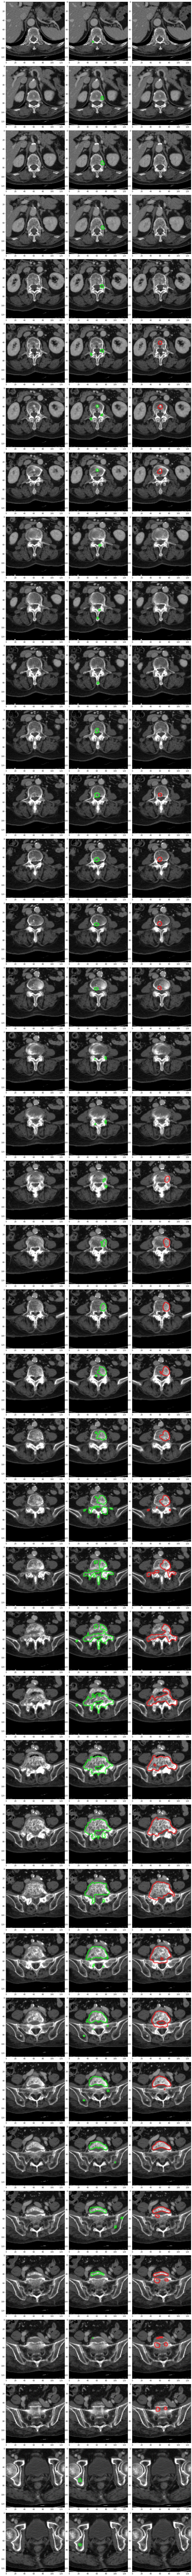

In [24]:
plot_img_label_pred((adjust_window(image,(700,200))*255).astype(np.uint8), label.astype(np.uint8), pred_t.numpy().astype(np.uint8), show_only_positive = True, interval =2)